## In this Notebook, we will work on [**Gene expression RNA-seq** Dataset](https://archive.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

X = pd.read_csv("Datasets/TCGA-PANCAN-HiSeq-801x20531/data.csv")
y = pd.read_csv("Datasets/TCGA-PANCAN-HiSeq-801x20531/labels.csv")

##### The target label is One class of the following classes:  

>**KIRC**: Kidney Renal Clear Cell Carcinoma  
>**PRAD**: Prostate Adenocarcinoma  
>**COAD**: Chronic Obstructive Pulmonary Disease (_Lungs_)  
>**LUAD**: Lung Adenocarcinoma (_also Lungs_)  
>**BRCA**: Breast Cancer $Gene$ (_consist of BCRA1 & BCRA2_)  

##### The baseline level of performance of working with RNA sequence is:  
- for models:
  - Simple models: **60-80%**
  - Complex models (_e.g. NN_): **90+%**
- While students often reports a **90-95%** accuracy for _deep learning_ model in RNA sequence-based cancer classification.

- $Goal$:  Make a RNA seq-based cancer classification model of **90+%** Accuracy.



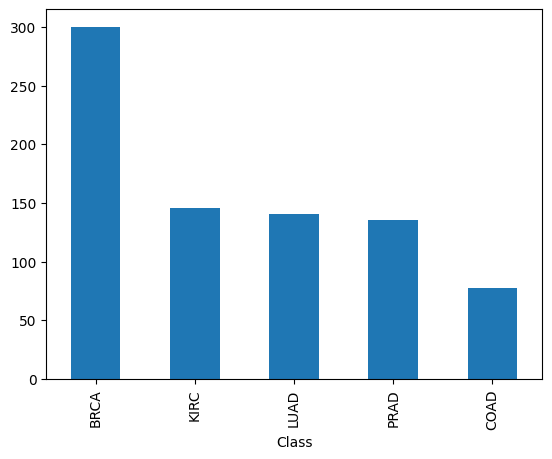

In [2]:
df = pd.concat([X, y], axis=1)

df['Class'].value_counts().plot(kind='bar')
plt.show()

From the plot, we notice that our dataset is _unbalanced_, and the model may overfit some training patterns while completely ignore others based on the `random_state` value. An initial way to solve this is to **straify** the examples when splitting them based on classes of y, so that every class has the same train to test ratio of examples.  
Another way to solve such problem is to choose a good model to work with unbalanced datasets, like **`Random Forest`** or **`Gradient Boosting`**.  

##### First let's clean our dataset from any redundant features:  
- We can control the tolerable variance of features to get only the significant features.
- Or we can use a _Dimentionality Reduction_ method like **Principal Component Analysis (PCA)** to the most $X$ amount of components significant to predict our target label

In [3]:
feature_columns = df.columns.difference(['Unnamed: 0', 'Class']) # Removing unnecessary columns..
low_variance_mask = df[feature_columns].var() < 1e-4 
filtered_features = df[feature_columns].loc[:, ~low_variance_mask]


In [4]:
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(filtered_features, y, test_size=0.2, stratify=y)

scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now let's test different values of the _hyperparameter_ $n$ _components, to deduce what's the best amount of components that best define the model with minimal information loss:    

In [5]:
components_to_test = [10, 20, 30, 40, 50, 100]
accuracy_scores = []

for n_components in components_to_test:
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_train)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X_reduced, y_train, cv=5, scoring='recall_macro')
    
    accuracy_scores.append(np.mean(scores))
    print(f"n_components={n_components}, Accuracy={np.mean(scores):.4f}")

optimal_n = components_to_test[np.argmax(accuracy_scores)]
print(f"Optimal n_components: {optimal_n}")


pca = PCA(n_components=optimal_n)  # Reduction of input features..
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

n_components=10, Accuracy=0.9732
n_components=20, Accuracy=0.9741
n_components=30, Accuracy=0.9778
n_components=40, Accuracy=0.9750
n_components=50, Accuracy=0.9686
n_components=100, Accuracy=0.9697
Optimal n_components: 30


It looks like the best `recall` values comes from only $20$ components.  
###### We're focusing on recall as it's very important in our medical application to tell the case if it has any signs of a specific cancer _even if it's not for certain that he has cancer_.  


Now let's train the model using the `RandomForestClassifier` on our preprocessed data:  


In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        60
        COAD       1.00      1.00      1.00        16
        KIRC       1.00      0.93      0.97        30
        LUAD       0.97      1.00      0.98        28
        PRAD       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161

0.9875776397515528


The model's acuuracy ranges from $95.6\%-99.38\%$ with some variation in between:  
```python
(99.38 + 98.76 + 97.52 + 98.14 + 95.6) / 5
(99.38 + 95.6 ) / 2
```
> Therfore the model averages about $97.88\%$ which is better than the baseline performance of working on RNA-Seq datasets!  

Now let's save the model, as well as all the preprocessing steps:  

In [7]:
from joblib import dump

model_data = {'std_scaler': scaler, 'pca': pca, 'model': model}
dump(model_data, "Models/rna-seq_classifier.pkl")

['Models/rna-seq_classifier.pkl']

#### Now let's save a few samples for testing later:   

In [8]:
subset = filtered_features.sample(n=5, replace=False)

for i in range(subset.shape[0]):
    subset.iloc[i].to_csv(f"Test Samples/rna-seq/sample_{i+1}.csv", index=False)

Now let's try to preprocess the data and test the model on the samples:  

In [9]:
for i in range(subset.shape[0]):
    sample = pd.read_csv(f"Test Samples/rna-seq/sample_{i+1}.csv")
    sample = sample.to_numpy().reshape(1, -1)

    sample = scaler.transform(sample)
    sample = pca.transform(sample)
    print(f"Sample {i+1} predicted class: {model.predict(sample)[0]}")

Sample 1 predicted class: BRCA
Sample 2 predicted class: BRCA
Sample 3 predicted class: LUAD
Sample 4 predicted class: BRCA
Sample 5 predicted class: KIRC


#### It seems to be working correctly, than means our work here is finally done!  

### End of Notebook